## **Configurations**

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=3baf58003f450e2d5729957fc17bebf07c7e5122f054972a4b1fd1c55d911ce3
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
id='1E-voIV2ctU4Brw022Na8RHVVRGOoNkO1'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('data.txt')

id='1yXNlZWMqUcAwDScBrkFChOHJwR1FZXmI'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('c1.txt')  

id='1vfovle9DgaeK0LnbQTH0j7kRaJjsvLtb'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('c2.txt') 

In [6]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.linalg import Vectors
import numpy as np
  
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **Q1**

In [34]:
def parse_point(line):
    return Vectors.dense([float(x) for x in line.split()])

data_rdd = sc.textFile("data.txt").map(parse_point)  

In [35]:
def parse_centroid(line):    
    return Vectors.dense([float(x) for x in line.split()])  
      
with open("c1.txt", "r") as file:    
    initial_centroids_c1 = [parse_centroid(line.strip()) for line in file] 

In [36]:
def parse_centroid(line):        
    return Vectors.dense([float(x) for x in line.split()])
      
with open("c2.txt", "r") as file:   
    initial_centroids_c2 = [parse_centroid(line.strip()) for line in file] 

In [37]:
def euclidean_distance(a, b):  
    return np.sqrt(np.sum((np.array(a) - np.array(b)) ** 2))

In [38]:
def manhattan_distance(a, b):
    return np.sum(np.abs(np.array(a) - np.array(b)))  

In [39]:
def kmeans(centroids, distance_metric, MAX_ITER):  
  costs = []   

  for i in range(1, MAX_ITER + 1):    
    
    if distance_metric == "Euclidean":
      # every element in clusters: (centroid, ((point, 1), cost_for_every_data_point))
      clusters_and_costs = data_rdd.map(lambda point: (np.argmin([euclidean_distance(point, c) for c in centroids]),
                                                     ((point, 1), np.min([euclidean_distance(point, c) ** 2 for c in centroids]))))
    if distance_metric == "Manhattan":
      clusters_and_costs = data_rdd.map(lambda point: (np.argmin([manhattan_distance(point, c) for c in centroids]),
                                                     ((point, 1), np.min([manhattan_distance(point, c) for c in centroids]))))
  
    # calculate the cost 
    total_cost = clusters_and_costs.map(lambda x: x[1][1]).sum()  
    costs.append(total_cost)

    # calculate new centroid for every cluster
    new_centroids = clusters_and_costs.map(lambda x: (x[0], x[1][0])) \
                                     .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
                                     .map(lambda x: x[1][0] / x[1][1]) \
                                     .collect()

    centroids = new_centroids

  return costs

## (a) 1

In [40]:
MAX_ITER = 20       
k = 10  

In [41]:
costs_Euclidean_c1 = kmeans(initial_centroids_c1, "Euclidean", MAX_ITER)
costs_Euclidean_c2 = kmeans(initial_centroids_c2, "Euclidean", MAX_ITER)

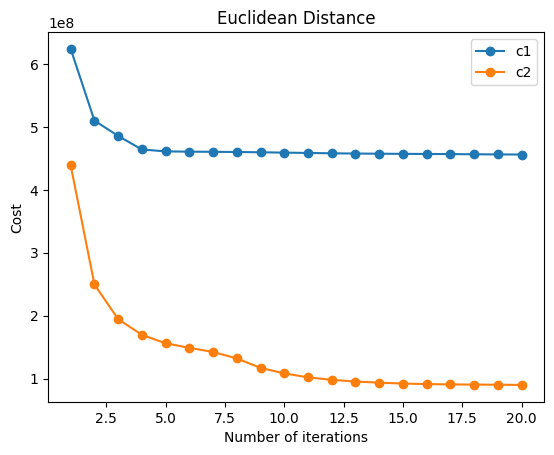

In [50]:
plt.plot(range(1, MAX_ITER + 1), costs_Euclidean_c1, label="c1", marker='o',)
plt.plot(range(1, MAX_ITER + 1), costs_Euclidean_c2, label="c2", marker='o')
plt.xlabel("Number of iterations")
plt.ylabel("Cost")         
plt.legend()       
plt.title("Euclidean Distance")
plt.savefig("a.png", dpi=300, bbox_inches="tight")
plt.show()  

## (a) 2

In [43]:
def percentage_change(cost_list):
  return (cost_list[0] - cost_list[10])/ cost_list[0]  

In [44]:
print("The percentage change using c1.txt and Euclidean Distance is: ", percentage_change(costs_Euclidean_c1))
print("The percentage change using c2.txt and Euclidean Distance is: ", percentage_change(costs_Euclidean_c2))   

The percentage change using c1.txt and Euclidean Distance is:  0.2648391714456055
The percentage change using c2.txt and Euclidean Distance is:  0.7669795594605946


## (b) 1

In [45]:
costs_Manhattan_c1 = kmeans(initial_centroids_c1, "Manhattan", MAX_ITER)
costs_Manhattan_c2 = kmeans(initial_centroids_c2, "Manhattan", MAX_ITER)

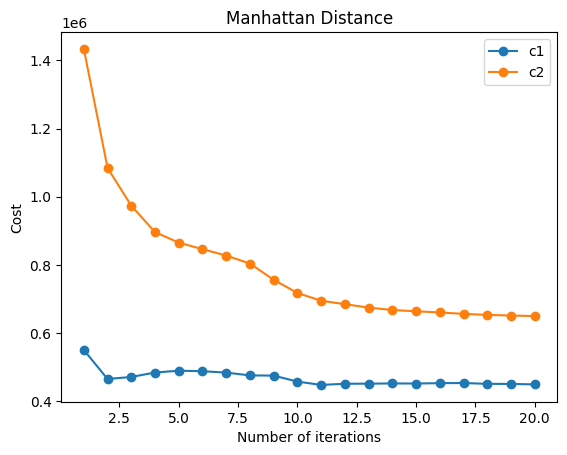

In [51]:
plt.plot(range(1, MAX_ITER + 1), costs_Manhattan_c1, label="c1", marker='o',)
plt.plot(range(1, MAX_ITER + 1), costs_Manhattan_c2, label="c2", marker='o')
plt.xlabel("Number of iterations")
plt.ylabel("Cost")       
plt.legend()         
plt.title("Manhattan Distance")   
plt.savefig("b.png", dpi=300, bbox_inches="tight")
plt.show()        

## (b) 2 

In [47]:
print("The percentage change using c1.txt and Manhattan Distance is: ", percentage_change(costs_Manhattan_c1))
print("The percentage change using c2.txt and Manhattan Distance is: ", percentage_change(costs_Manhattan_c2))   

The percentage change using c1.txt and Manhattan Distance is:  0.1865492611679923
The percentage change using c2.txt and Manhattan Distance is:  0.515540991023891
